In [5]:
import os
import re
import jieba
import time
import numpy as np
from keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import auc


In [2]:
def preprocess_keras(text):
    text1 = re.sub('&nbsp', ' ', text)
    # remove punctuation
    str_no_punctuation = re.sub(token, ' ', text1)  
    # words list
    text_list = list(jieba.cut(str_no_punctuation))  
    # delete space and stop_words
    text_list = [item for item in text_list if item != ' ' and item not in stopwords] 
    return ' '.join(text_list)


In [3]:
def load_raw_datasets():    
    labels = []
    texts = []
    base_dir = 'Reduced'
    t1 = time.time()
    for cate_index, label in enumerate(os.listdir(base_dir)):
        label_dir = os.path.join(base_dir, label)
        file_list = os.listdir(label_dir)
        labels_index[label] = cate_index 
        if 'ipynb' in label:
            continue
        print("label: {}, len: {}".format(label, len(file_list)))

        for fname in file_list:
            if 'txt' in fname:
                f = open(os.path.join(label_dir, fname), encoding='gb2312', errors='ignore')
                texts.append(preprocess_keras(f.read()))
                f.close()
                labels.append(labels_index[label])
            
    t2 = time.time()
    tm_cost = t2-t1
    print('\nDone. {} total categories, {} total docs. cost {} seconds.'.format(len(os.listdir(base_dir))-1, len(texts), tm_cost))
    return texts, labels

In [4]:
# get crawling data from database
def load_self_data():
    from read_database import get_news
    news_list = get_news()
    return news_list

In [7]:
#jieba.enable_parallel() 

token = "[0-9\s+\.\!\/_,$%^*()?;；：【】+\"\'\[\]\\]+|[+——！，;:。？《》、~@#￥%……&*（）“”.=-]+"

# record order of classification labels
labels_index = {} 

# stop_words
stopwords = set(open('dict/stop_words.txt', encoding='utf-8').read().split()) 


In [6]:
from keras.models import load_model
from myutils import clean_doc, clean_doc_HAN
import pickle
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import numpy as np
from keras.preprocessing.text import text_to_word_sequence

texts, labels = load_raw_datasets()



Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Choi\AppData\Local\Temp\jieba.cache


label: C000008, len: 1992


Loading model cost 0.520 seconds.
Prefix dict has been built successfully.


label: C000010, len: 1990
label: C000013, len: 1990
label: C000014, len: 1990
label: C000016, len: 1990
label: C000020, len: 1990
label: C000022, len: 1990
label: C000023, len: 1990
label: C000024, len: 1990

Done. 9 total categories, 17910 total docs. cost 64.44214606285095 seconds.


In [7]:
import os
import re
import jieba
import time
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Embedding, Input
from keras.layers import Conv1D, MaxPooling1D, Flatten

MAX_SEQUENCE_LEN = 1000  # sequence length
MAX_WORDS_NUM = 20000  # max words
VAL_SPLIT_RATIO = 0.2 # ratio for validation
EMBEDDING_DIM = 300 # embedding dimension

# process datasets by keras API

tokenizer = Tokenizer(num_words=MAX_WORDS_NUM)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(len(word_index)) # all token found

dict_swaped = lambda _dict: {val:key for (key, val) in _dict.items()}
word_dict = dict_swaped(word_index) # swap key-value
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LEN)

labels_categorical = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels_categorical.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels_categorical = labels_categorical[indices]

# split data by ratio
val_samples_num = int(VAL_SPLIT_RATIO * data.shape[0])
x_train = data[:-val_samples_num]
y_train = labels_categorical[:-val_samples_num]
x_val = data[-val_samples_num:]
y_val = labels_categorical[-val_samples_num:]


264202
Shape of data tensor: (17910, 1000)
Shape of label tensor: (17910, 10)


In [8]:
embedding_layer = Embedding(input_dim=MAX_WORDS_NUM+1,
                            output_dim=EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LEN,
                            trainable=False)


sequence_input = Input(shape=(MAX_SEQUENCE_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

cp=ModelCheckpoint(f"ch_model_cnn.h5",monitor='val_loss',verbose=1,save_best_only=True, mode="min")
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=2,
                          verbose=1)

history = model.fit(x_train, 
                    y_train,
                    epochs=15,
                    batch_size=50,
                    validation_data=(x_val, y_val),
                    callbacks=[cp, earlystop])


Epoch 1/15
478/478 [==============================] - ETA: 0s - loss: 1.6148 - acc: 0.3845
Epoch 1: val_loss improved from inf to 1.08613, saving model to ch_model_cnn.h5
478/478 [==============================] - 51s 105ms/step - loss: 1.6148 - acc: 0.3845 - val_loss: 1.0861 - val_acc: 0.5932
Epoch 2/15
478/478 [==============================] - ETA: 0s - loss: 0.8643 - acc: 0.6883
Epoch 2: val_loss improved from 1.08613 to 0.77382, saving model to ch_model_cnn.h5
478/478 [==============================] - 52s 109ms/step - loss: 0.8643 - acc: 0.6883 - val_loss: 0.7738 - val_acc: 0.7423
Epoch 3/15
478/478 [==============================] - ETA: 0s - loss: 0.5153 - acc: 0.8294
Epoch 3: val_loss improved from 0.77382 to 0.64332, saving model to ch_model_cnn.h5
478/478 [==============================] - 52s 108ms/step - loss: 0.5153 - acc: 0.8294 - val_loss: 0.6433 - val_acc: 0.7965
Epoch 4/15
478/478 [==============================] - ETA: 0s - loss: 0.3102 - acc: 0.8961
Epoch 4: val_los

In [9]:
with open('model/ch_tokenizer_cnn.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("tokenizer has been saved.")

tokenizer has been saved.


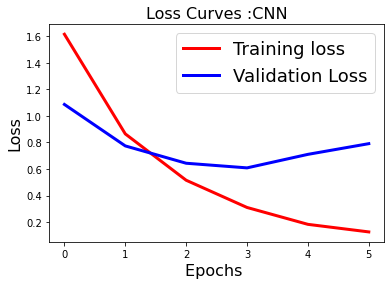

In [15]:

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('ch_loss_cnn.png')
plt.show()

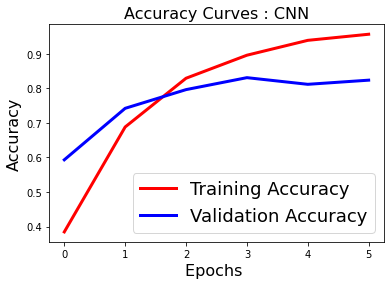

In [16]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('ch_accuracy_cnn.png')
plt.show()

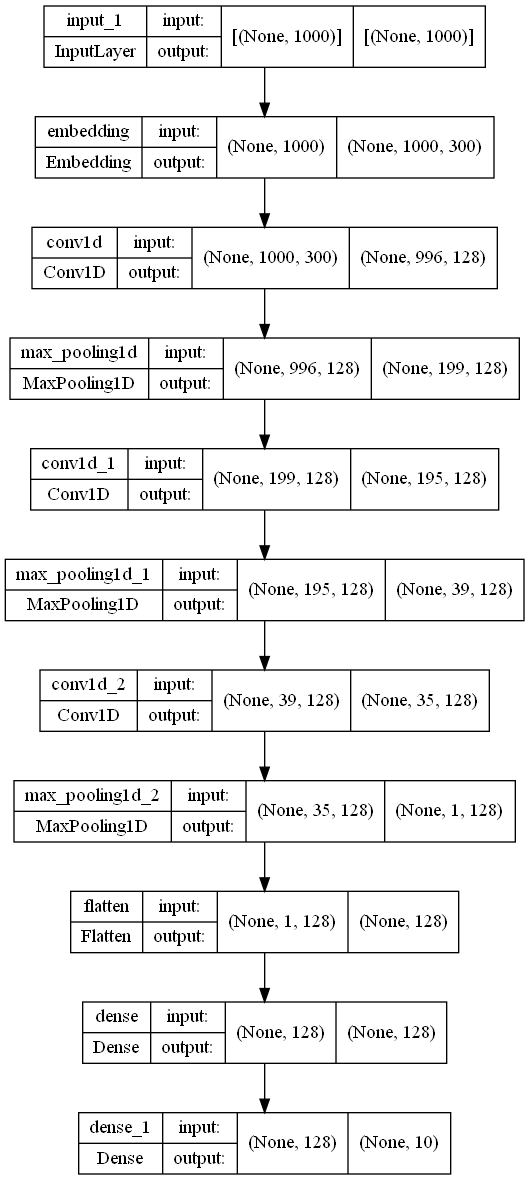

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='ch_cnn_model.png', show_shapes=True, show_layer_names=True)

In [8]:
# -*- coding: utf-8 -*-
import bson
import re
bson_file = open('sina_news.bson', 'rb')
bson_data = bson.decode_all(bson_file.read())
texts_sina = []
original_text = []
for data in bson_data:
    original_text.append(data['news'])
    texts_sina.append(preprocess_keras(data['news']))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Choi\AppData\Local\Temp\jieba.cache
Loading model cost 0.545 seconds.
Prefix dict has been built successfully.


In [9]:
# CNN
from keras.models import load_model
from myutils import clean_doc
import pickle
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import numpy as np


MAX_SEQUENCE_LENGTH = 1000

with open('model/ch_tokenizer_cnn.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    


sequences_test = tokenizer.texts_to_sequences(texts_sina)
X_test_word    = pad_sequences(
    sequences_test,
    maxlen  = MAX_SEQUENCE_LENGTH,
    padding = 'post'
)


test_loss = []
test_accs = []


cnn_ = load_model(f"ch_model_cnn.h5")
pre_result = cnn_.predict(X_test_word, batch_size=50)


    


In [19]:
class_sina = ['Finance', 'IT', 'Health', 'Sports', 'Travel', 'Education', 'Recruit', 'Culture', 'Military']

In [24]:
for i in range(len(original_text)):
    print('Original text is: '+original_text[i])
    predi_max_val = max(pre_result[i])
    pre_index = list(pre_result[i]).index(predi_max_val)
    print('Predicted lable is: '+class_sina[pre_index])
    

Original text is: 河北部分地区推行防贫保险 经过大数据测算，财政部门拿出400万元防贫保险金，以“非贫困低收入户”“非持续稳定脱贫户”为重点，为涞源县10%左右的农村人口购买保险，主要保障因病、因灾、因学致贫或返贫。涞源县扶贫办副主任罗杰说，保险的保障对象不事先确定和识别，而是根据大数据分析，确定医疗、就学、灾情等方面的支出预警线。农村非贫困人口一旦被监控到某项支出超了预警线，相关单位随即启动跟踪程序入户调查，符合保障条件的再进行评议、公示等，便可发放防贫保险金，并落实其他帮扶措施。
Predicted lable is: Education
Original text is: 内蒙古奶和玉米产业突破千亿级6日从内蒙古自治区政府获悉，新中国成立70年来，内蒙古着力发展壮大农牧业产业，目前已打造出奶产业和玉米产业2个千亿级农牧产业，形成了肉羊等8个百亿级优势产业，农牧业高质量发展迈出坚实步伐。
Predicted lable is: Health
Original text is: 上交所官网显示，北京金山办公软件股份有限公司科创板IPO提交注册。
Predicted lable is: Education
Original text is: 国家外汇管理局新闻发言人、总经济师王春英：我国经济发展有巨大的韧性、潜力和回旋余地，长期向好的发展态势没有改变，并继续推进全方位改革开放，这将为外汇储备规模保持总体稳定提供有力支撑。
Predicted lable is: Education
Original text is: 国家外汇管理局新闻发言人、总经济师王春英：9月，我国外汇市场供求保持基本平衡。受全球经济增长、主要国家央行货币政策、全球贸易局势、地缘政治因素等影响，美元指数上涨，主要国家债券价格下跌。汇率折算和资产价格变化等因素综合影响外汇储备规模。
Predicted lable is: Health
Original text is: 火箭队中国赞助商浦发银行：暂停相关活动和宣传 休斯顿火箭队在中国的赞助商浦发银行信用卡中心发表声明：祖国尊严高于一切，已暂停相关市场活动和宣传，并继续敦促休斯顿火箭队对此事件展开彻查并给予合理回复。
Predicted lable is: Education
Original text is: 中国央行数据显示，9